In [89]:
import pandas as pd
import numpy as np
import sklearn

from fredapi import Fred
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Gathering Initial Data for MVP

In [90]:
# Use FRED API to get latest releases in form of Series
fred = Fred(api_key = 'ef21eaa55b4aa6b62a37a05a6ba071c6')

# Series to pull
ten_year = fred.get_series_latest_release('GS10') #10 Year Treasury Yield
three_month = fred.get_series_latest_release('TB3MS') #3 Month Treasury Yield
recession = fred.get_series_latest_release('USREC') #Dummy variable for recession based on NBER
consumer_sent = fred.get_series_latest_release('CSCICP03USM665S') #OECD Consumer sentiment

In [166]:
fred_data = pd.concat([ten_year, three_month, consumer_sent, recession], axis=1).reset_index()
fred_data.columns = ['Date', '10_Year','3_Month','Consumer Sentiment','Recession']

In [167]:
fred_data.head()

,Date,10_Year,3_Month,Consumer Sentiment,Recession
0,1854-12-01,NaN,NaN,NaN,1.0
1,1855-01-01,NaN,NaN,NaN,0.0
2,1855-02-01,NaN,NaN,NaN,0.0
3,1855-03-01,NaN,NaN,NaN,0.0
4,1855-04-01,NaN,NaN,NaN,0.0


In [168]:
fred_data.dropna(inplace = True)
df = fred_data.copy()
df.reset_index(drop = True, inplace = True)

In [169]:
df['10Y-3M'] = df['10_Year'] - df['3_Month']

In [170]:
df.head(5)

,Date,10_Year,3_Month,Consumer Sentiment,Recession,10Y-3M
0,1960-01-01,4.72,4.35,101.492291,0.0,0.37
1,1960-02-01,4.49,3.96,101.239199,0.0,0.53
2,1960-03-01,4.25,3.31,101.020550,0.0,0.94
3,1960-04-01,4.28,3.23,100.899940,0.0,1.05
4,1960-05-01,4.35,3.29,100.930390,1.0,1.06


## EDA

Have to shift yield spreads forward a certain amount of time to see if spreads have any predictive power
into future

Let's start with 6 months, 12 months, and 18 months

In [171]:
df['10Y-3M 6M Forward'] = df.loc[:,'10Y-3M'].shift(periods=6)
df['10Y-3M 9M Forward'] = df.loc[:,'10Y-3M'].shift(periods=9)
df['10Y-3M 12M Forward'] = df.loc[:,'10Y-3M'].shift(periods=12)

df['C Sentiment 6M Forward'] = df.loc[:,'Consumer Sentiment'].shift(periods=6)
df['C Sentiment 9M Forward'] = df.loc[:,'Consumer Sentiment'].shift(periods=9)
df['C Sentiment 12M Forward'] = df.loc[:,'Consumer Sentiment'].shift(periods=12)

In [172]:
df.head(5)

,Date,10_Year,3_Month,Consumer Sentiment,Recession,10Y-3M,10Y-3M 6M Forward,10Y-3M 9M Forward,10Y-3M 12M Forward,C Sentiment 6M Forward,C Sentiment 9M Forward,C Sentiment 12M Forward
0,1960-01-01,4.72,4.35,101.492291,0.0,0.37,NaN,NaN,NaN,NaN,NaN,NaN
1,1960-02-01,4.49,3.96,101.239199,0.0,0.53,NaN,NaN,NaN,NaN,NaN,NaN
2,1960-03-01,4.25,3.31,101.020550,0.0,0.94,NaN,NaN,NaN,NaN,NaN,NaN
3,1960-04-01,4.28,3.23,100.899940,0.0,1.05,NaN,NaN,NaN,NaN,NaN,NaN
4,1960-05-01,4.35,3.29,100.930390,1.0,1.06,NaN,NaN,NaN,NaN,NaN,NaN


In [173]:
# df.dropna(inplace = True)
# df = df.drop(['10Y-2Y', '10Y-3M'], axis=1)

Quick EDA and time series plots of the spread's predicition ability

First take a look at current yield spreads vs. recessions

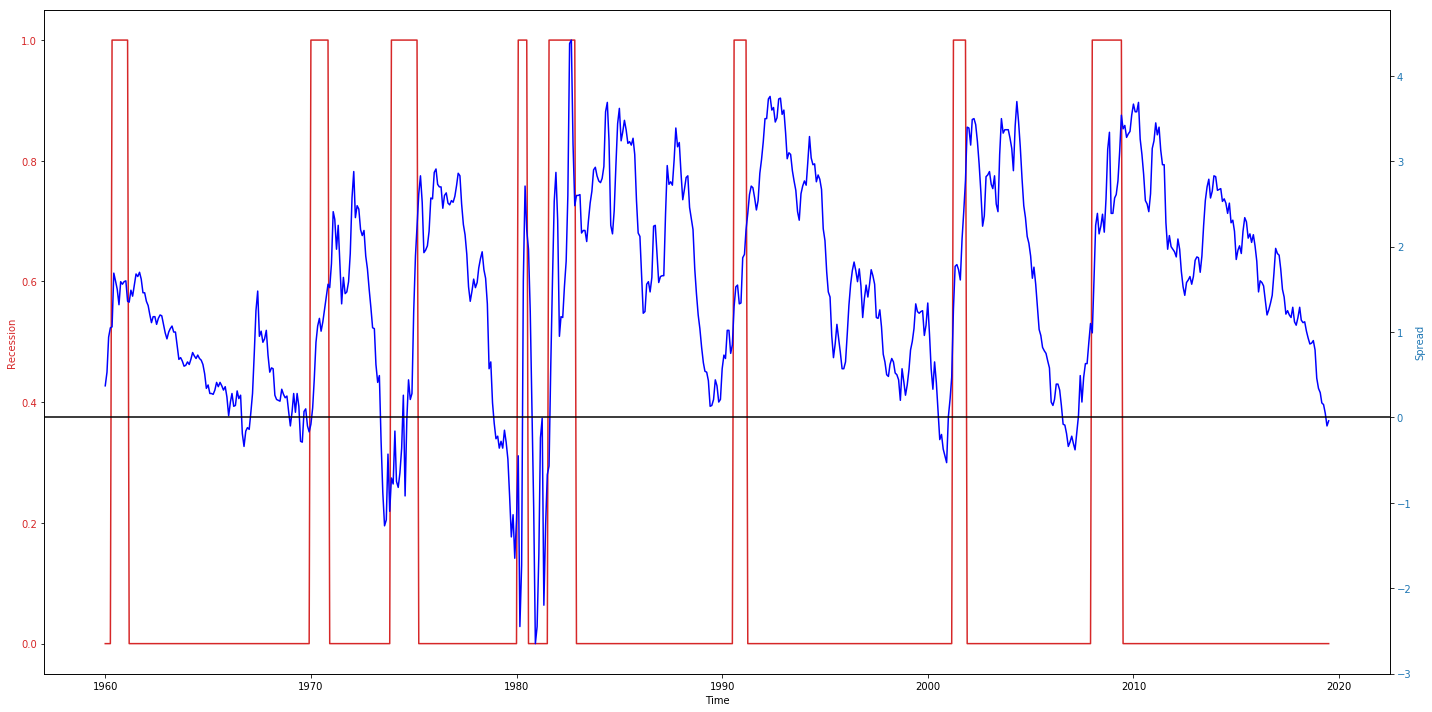

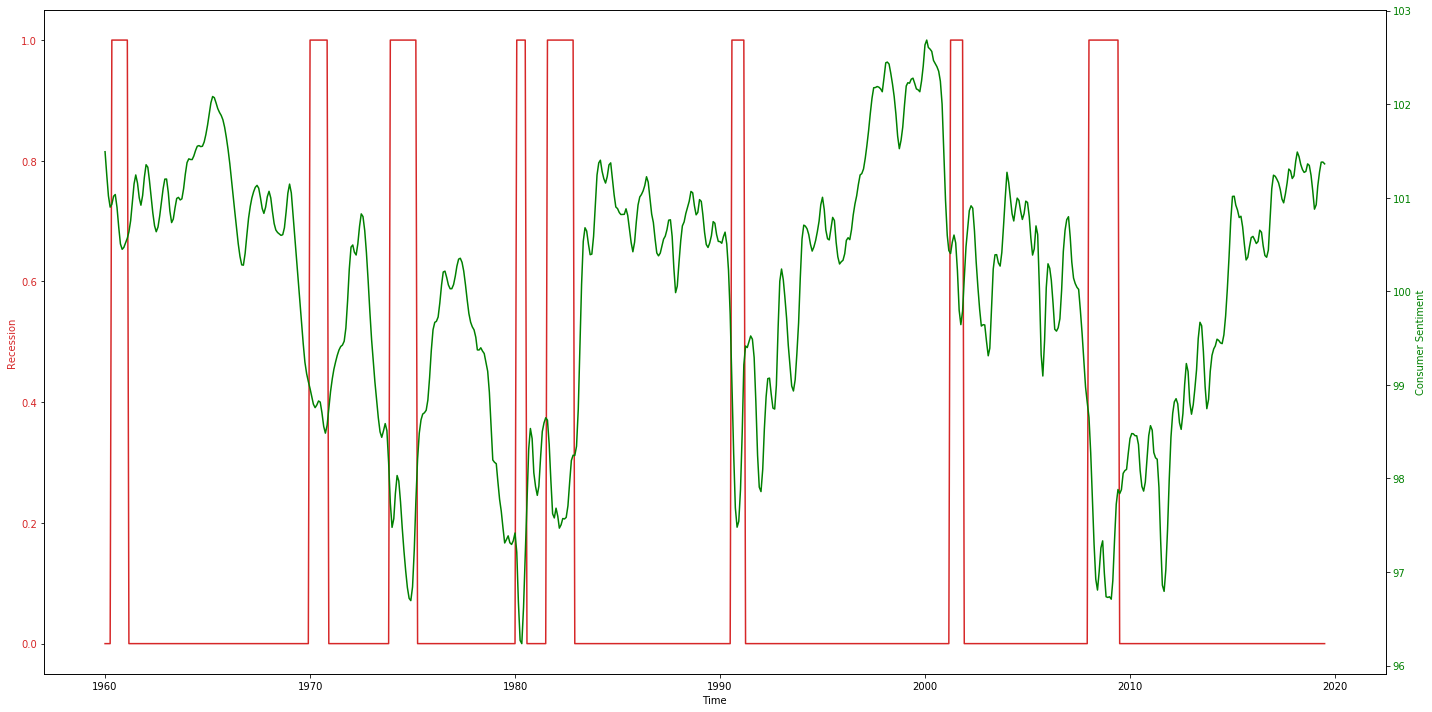

In [174]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(df['Date'], df['Recession'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Spread', color=color)  
ax2.plot(df['Date'], df['10Y-3M'], color='blue')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(0, color="black")
plt.show()

fig2, ax3 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax3.set_xlabel('Time')
ax3.set_ylabel('Recession', color=color)
ax3.plot(df['Date'], df['Recession'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax3.twinx()  

color = 'tab:blue'
ax4.set_ylabel('Consumer Sentiment', color='green')  
ax4.plot(df['Date'], df['Consumer Sentiment'], color='green')
ax4.tick_params(axis='y', labelcolor='green')

fig2.tight_layout()
plt.show();

Certainly seems like spreads have led the last few recessions. Now let's look at predictative ability of spreads for 6m

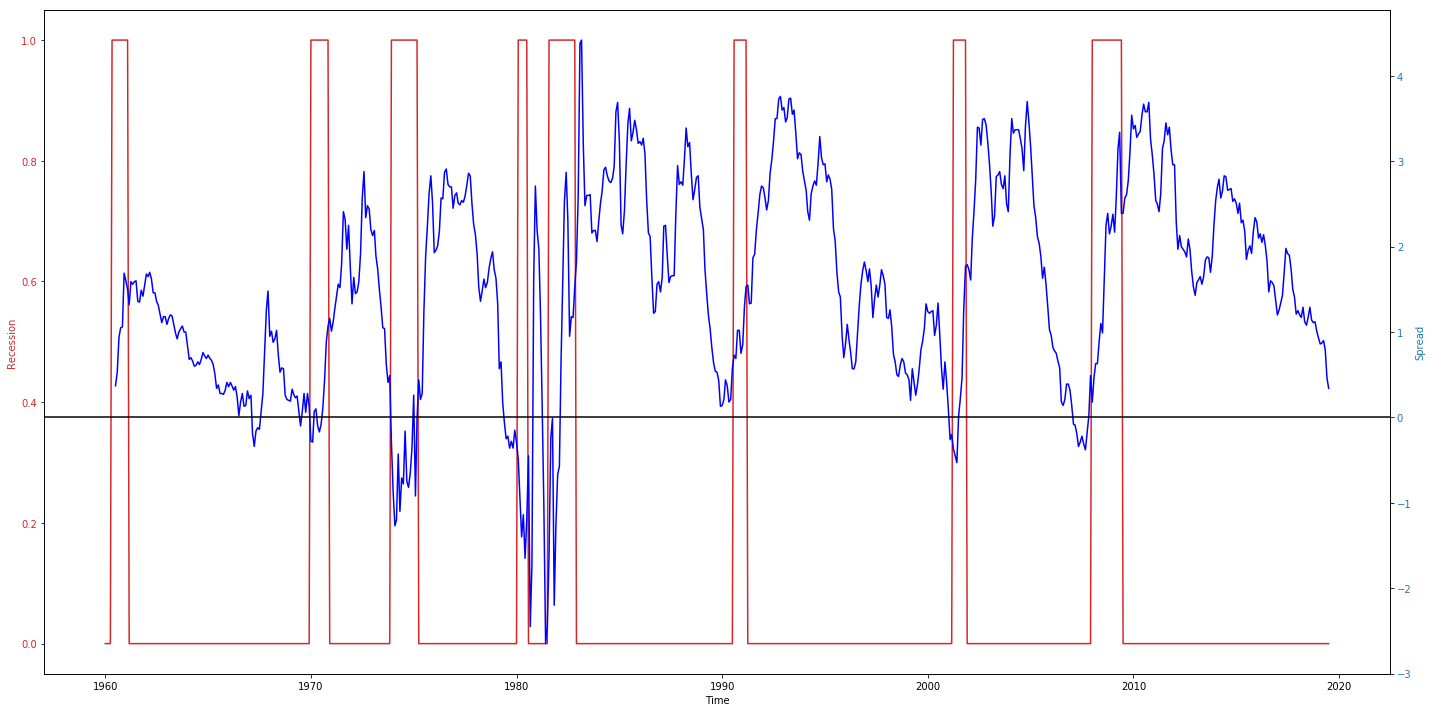

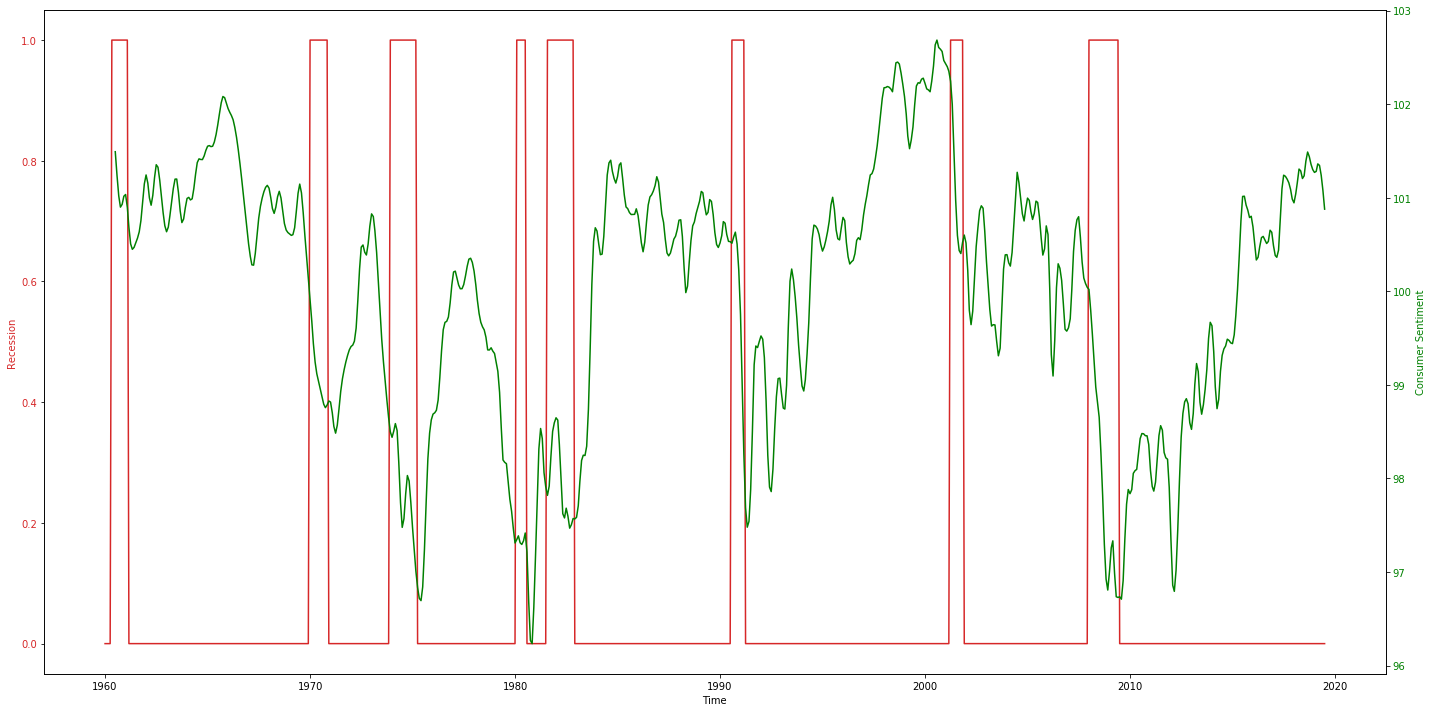

In [175]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(df['Date'], df['Recession'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Spread', color=color)  
ax2.plot(df['Date'], df['10Y-3M 6M Forward'], color='blue')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(0, color="black")
plt.show()

fig2, ax3 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax3.set_xlabel('Time')
ax3.set_ylabel('Recession', color=color)
ax3.plot(df['Date'], df['Recession'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax3.twinx()  

color = 'tab:blue'
ax4.set_ylabel('Consumer Sentiment', color='green')  
ax4.plot(df['Date'], df['C Sentiment 6M Forward'], color='green')
ax4.tick_params(axis='y', labelcolor='green')

fig2.tight_layout()
plt.show();

Not bad. Let's try 12 months too

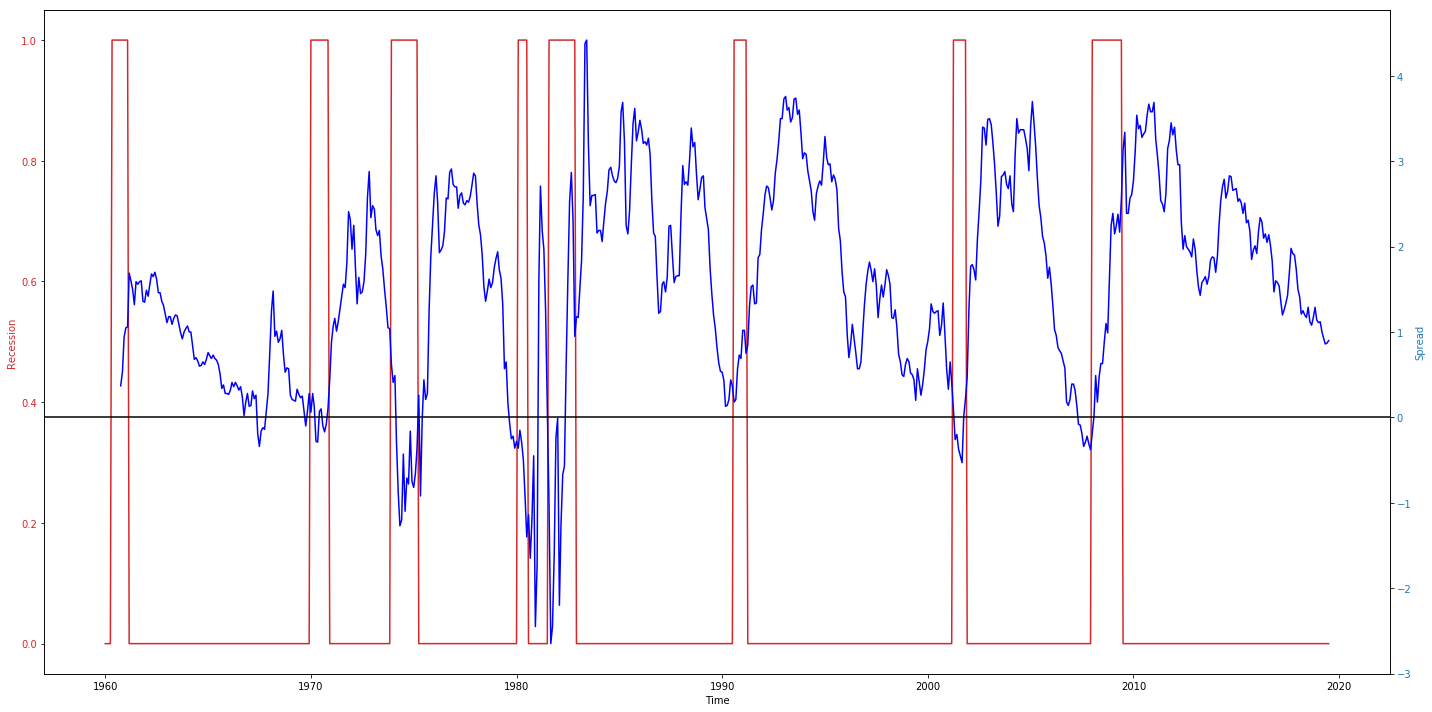

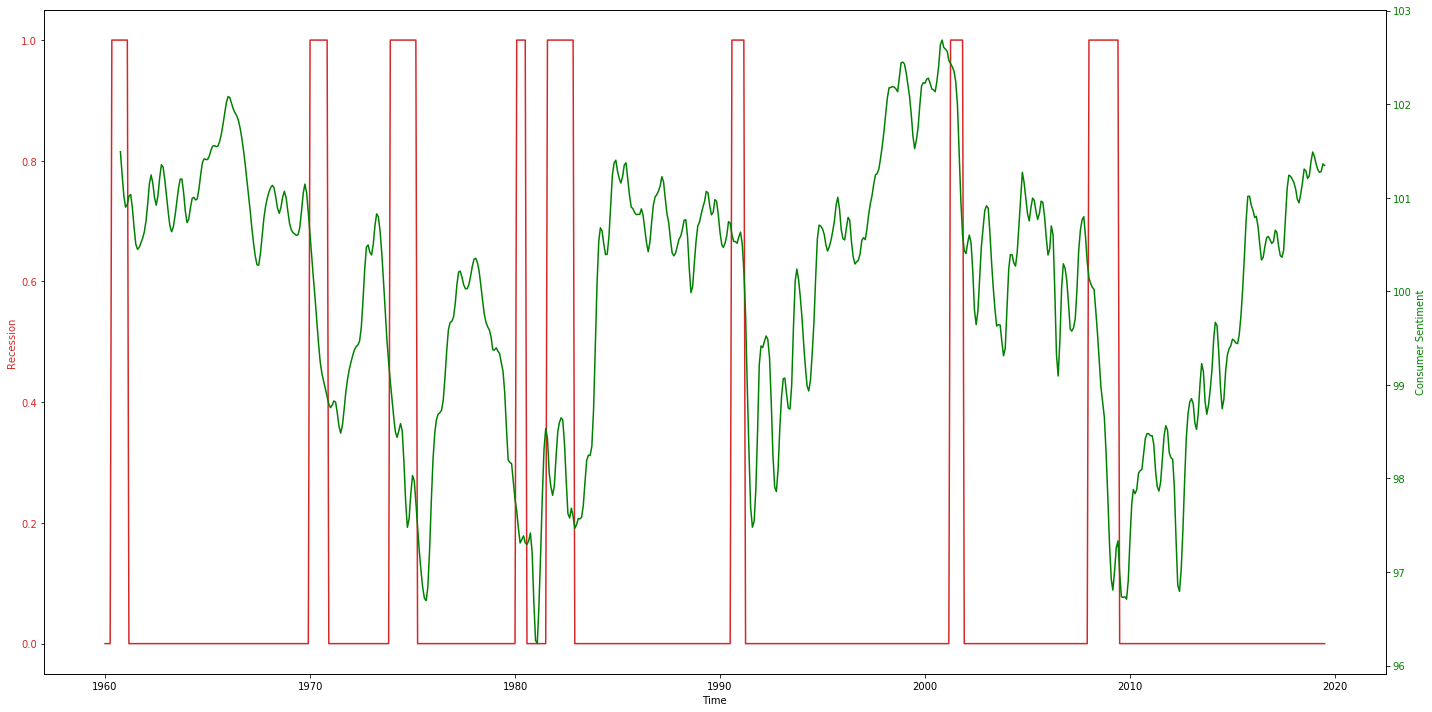

In [176]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(df['Date'], df['Recession'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Spread', color=color)  
ax2.plot(df['Date'], df['10Y-3M 9M Forward'], color='blue')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(0, color="black")
plt.show()

fig2, ax3 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax3.set_xlabel('Time')
ax3.set_ylabel('Recession', color=color)
ax3.plot(df['Date'], df['Recession'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax3.twinx()  

color = 'tab:blue'
ax4.set_ylabel('Consumer Sentiment', color='green')  
ax4.plot(df['Date'], df['C Sentiment 9M Forward'], color='green')
ax4.tick_params(axis='y', labelcolor='green')

fig2.tight_layout()
plt.show();

And one last time for 18 months

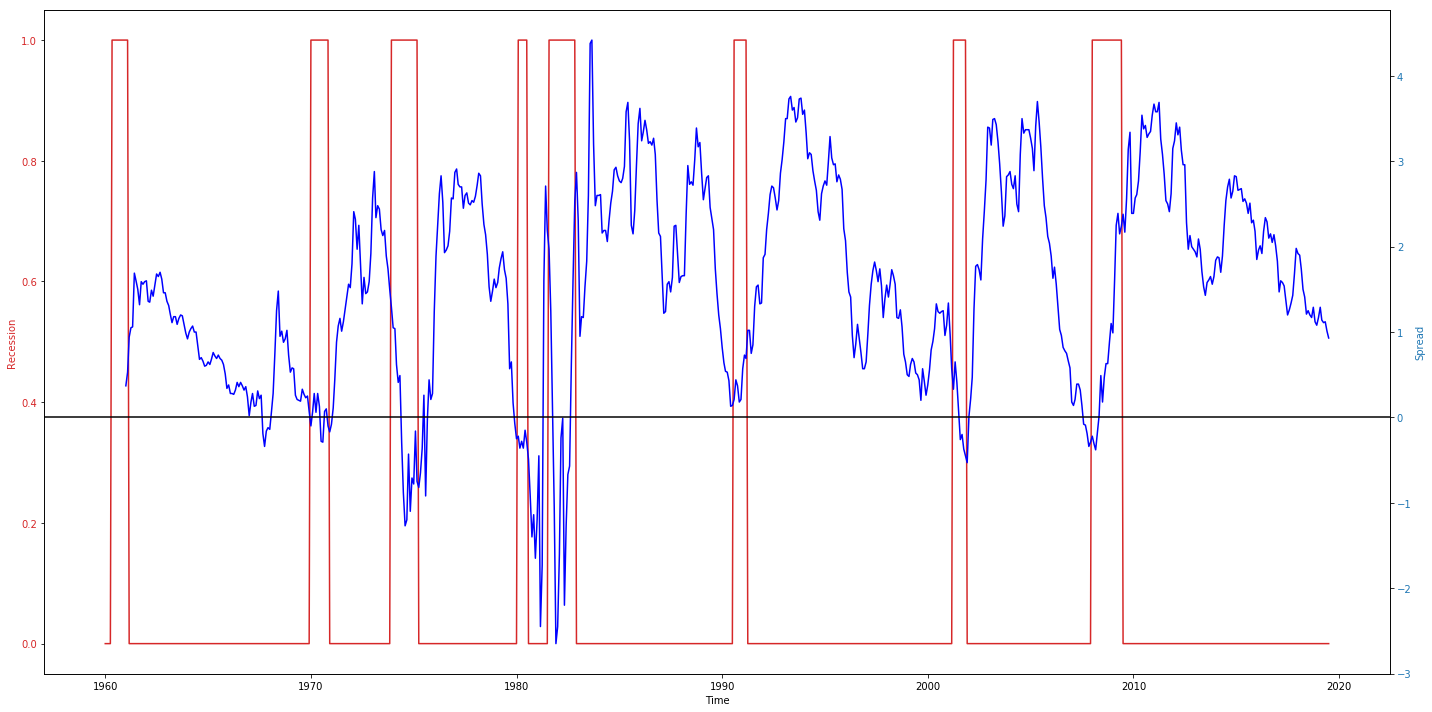

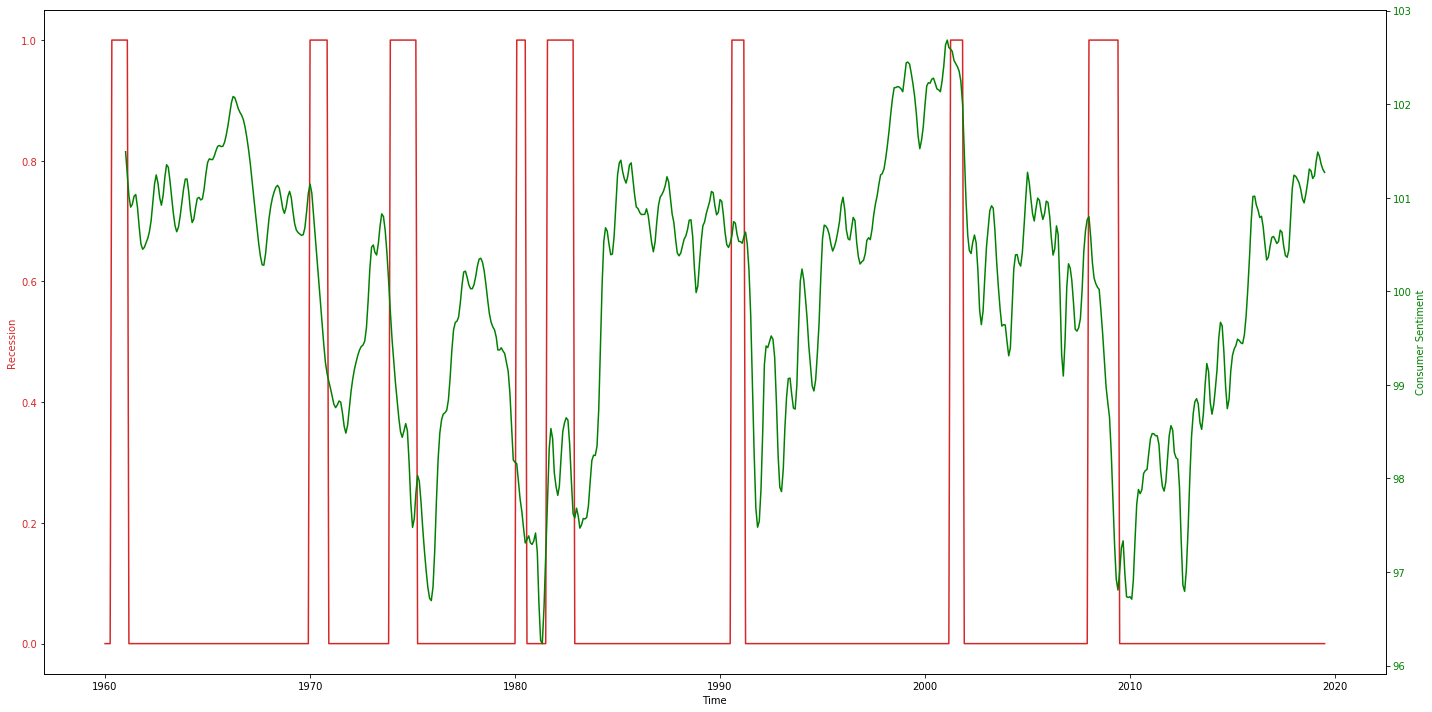

In [177]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(df['Date'], df['Recession'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Spread', color=color)  
ax2.plot(df['Date'], df['10Y-3M 12M Forward'], color='blue')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(0, color="black")
plt.show()

fig2, ax3 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax3.set_xlabel('Time')
ax3.set_ylabel('Recession', color=color)
ax3.plot(df['Date'], df['Recession'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax3.twinx()  

color = 'tab:blue'
ax4.set_ylabel('Consumer Sentiment', color='green')  
ax4.plot(df['Date'], df['C Sentiment 12M Forward'], color='green')
ax4.tick_params(axis='y', labelcolor='green')

fig2.tight_layout()
plt.show();

Overall, looks like the 6 month forward spread is best indicator of recession

## Logistic Regression for Recession Probabilities

In [239]:
df_logit = df[['Date','Recession','10Y-3M 12M Forward','C Sentiment 12M Forward']].copy()
df_logit.dropna(inplace = True)
#583 months

In [240]:
cutoff = round(len(df_logit) * 0.666)
cutoff

468

In [244]:
cross_validation = df_logit[:cutoff]
cross_validation = cross_validation.reset_index(drop = True)
test = df_logit[cutoff:]
test = test.reset_index(drop = True)

In [245]:
test.head()

,Date,Recession,10Y-3M 12M Forward,C Sentiment 12M Forward
0,2000-01-01,0.0,0.38,101.991091
1,2000-02-01,0.0,0.56,102.195055
2,2000-03-01,0.0,0.79,102.229610
3,2000-04-01,0.0,0.89,102.224893
4,2000-05-01,0.0,1.04,102.267610


In [249]:
y_train = cross_validation.Recession
y_test = test.Recession
X_train = cross_validation[['10Y-3M 12M Forward','C Sentiment 12M Forward']]
X_test = test[['10Y-3M 12M Forward','C Sentiment 12M Forward']]

In [250]:
std_scale = preprocessing.StandardScaler().fit(X_test)
X_test = std_scale.transform(X_test)

In [251]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)

In [252]:
logit = LogisticRegression(C = 0.95)
logit.fit(X_train, y_train)
y_predict = logit.predict(X_test)
print("The score for logistic regression is")
#score returns mean accuracy
print("Training: {:6.2f}%".format(100*logit.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*logit.score(X_test, y_test)))
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

The score for logistic regression is
Training:  88.46%
Test set:  88.94%
Default threshold:
Precision: 0.5000,   Recall: 0.1154


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [253]:
rec_probs = logit.predict_proba(X_test)
temp = pd.DataFrame(rec_probs)
temp['Date'] = test['Date']

In [254]:
temp.head()

,0,1,Date
0,0.770569,0.229431,2000-01-01
1,0.817618,0.182382,2000-02-01
2,0.858968,0.141032,2000-03-01
3,0.873750,0.126250,2000-04-01
4,0.894728,0.105272,2000-05-01


In [255]:
test = pd.concat([test, temp], axis=1)

In [256]:
test.dropna(inplace = True)
test.tail()

,Date,Recession,10Y-3M 12M Forward,C Sentiment 12M Forward,0,1,Date
230,2019-03-01,0.0,1.14,101.488998,0.886322,0.113678,2019-03-01
231,2019-04-01,0.0,1.11,101.440008,0.880947,0.119053,2019-04-01
232,2019-05-01,0.0,1.12,101.357301,0.879898,0.120102,2019-05-01
233,2019-06-01,0.0,1.01,101.301471,0.862241,0.137759,2019-06-01
234,2019-07-01,0.0,0.93,101.271164,0.848435,0.151565,2019-07-01


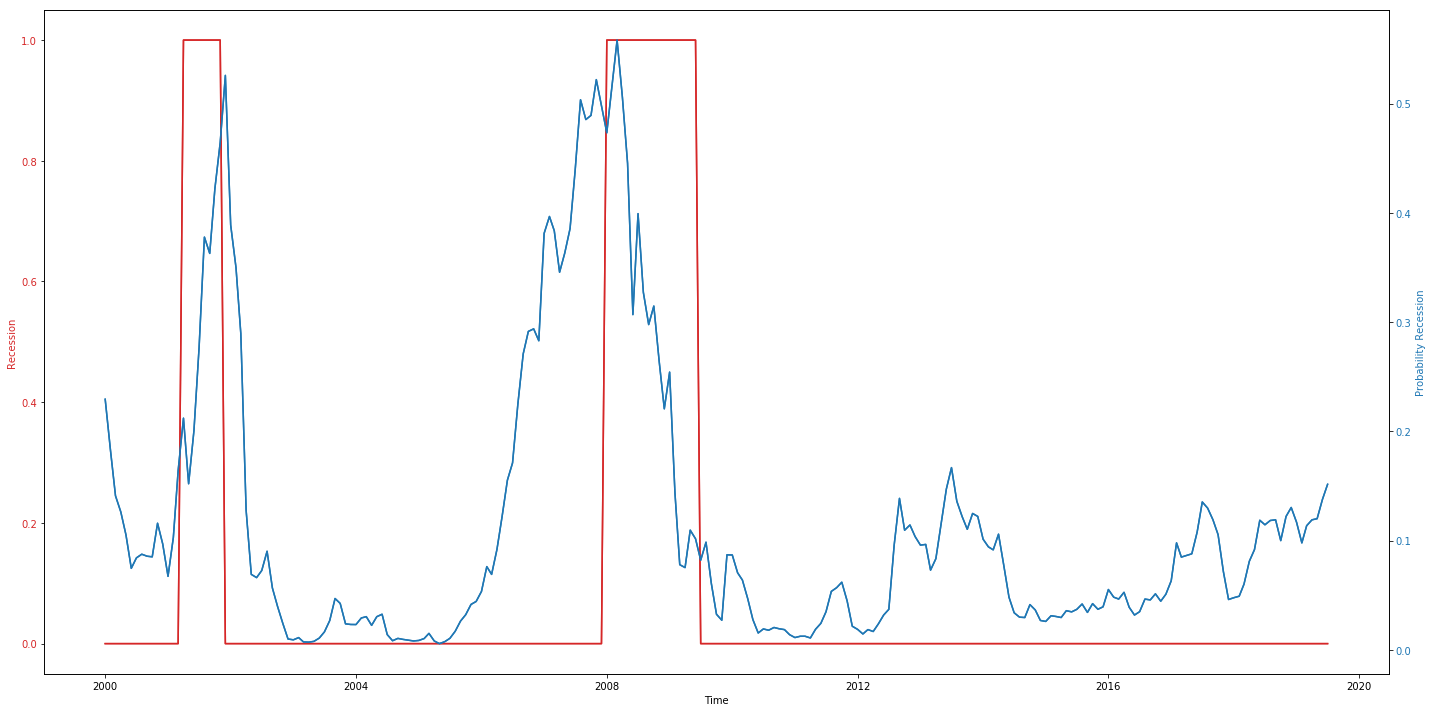

In [257]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(test['Date'], test['Recession'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Probability Recession', color=color)  
ax2.plot(test['Date'], test[1], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

Seems to be doing an ok job, but let's refit on entire dataset now

In [260]:
y = df_logit.Recession
X = df_logit[['10Y-3M 12M Forward','C Sentiment 12M Forward']]

In [261]:
std_scale = preprocessing.StandardScaler().fit(X)
X = std_scale.transform(X)

In [262]:
logit = LogisticRegression(C = 0.95)
logit.fit(X, y)
y_predict = logit.predict(X)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [263]:
rec_probs_2 = logit.predict_proba(X)
temp = pd.DataFrame(rec_probs_2)
temp.head()

,0,1
0,0.832953,0.167047
1,0.850047,0.149953
2,0.898327,0.101673
3,0.907313,0.092687
4,0.909015,0.090985


In [264]:
df_logit.reset_index(drop = True, inplace = True)
df_logit['Rec Prob'] = temp[1]

In [265]:
df_logit.head()

,Date,Recession,10Y-3M 12M Forward,C Sentiment 12M Forward,Rec Prob
0,1961-01-01,1.0,0.37,101.492291,0.167047
1,1961-02-01,1.0,0.53,101.239199,0.149953
2,1961-03-01,0.0,0.94,101.020550,0.101673
3,1961-04-01,0.0,1.05,100.899940,0.092687
4,1961-05-01,0.0,1.06,100.930390,0.090985


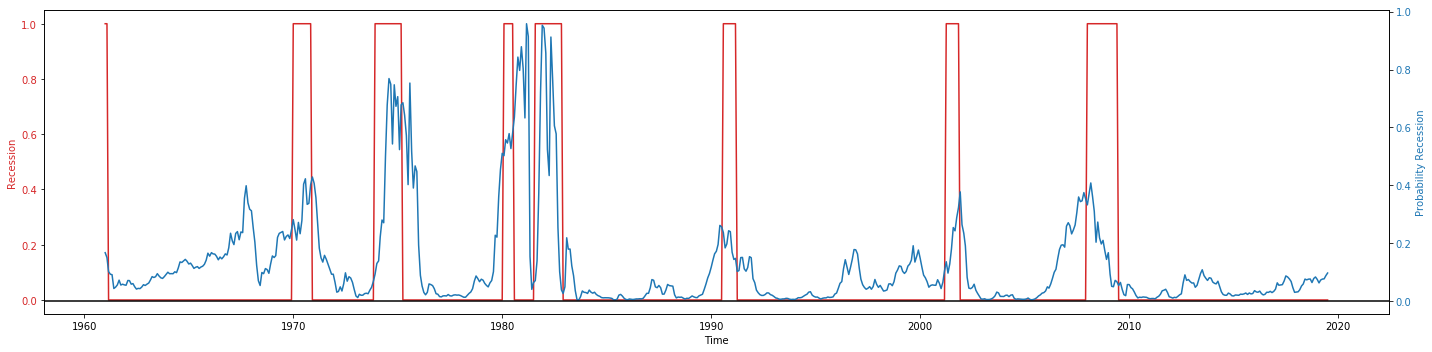

In [266]:
fig, ax1 = plt.subplots(figsize=(20,5))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(df_logit['Date'], df_logit['Recession'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Probability Recession', color=color)  
ax2.plot(df_logit['Date'], df_logit['Rec Prob'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(0, color="black")
plt.show()